In [81]:
####################################
#ENVIRONMENT SETUP

In [82]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
import xarray as xr

import sys; import os; import time; from datetime import timedelta
import pickle
import h5py

In [83]:
#MAIN DIRECTORIES
def GetDirectories():
    mainDirectory='/mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/'
    mainCodeDirectory=os.path.join(mainDirectory,"Code/CodeFiles/")
    scratchDirectory='/mnt/lustre/koa/scratch/air673/'
    codeDirectory=os.getcwd()
    return mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory

[mainDirectory,mainCodeDirectory,scratchDirectory,codeDirectory] = GetDirectories()

In [84]:
#IMPORT CLASSES (from current directory)
sys.path.append(os.path.join(mainCodeDirectory,"Variable_Calculation"))
from CLASSES_Variable_Calculation import ModelData_Class, SlurmJobArray_Class, DataManager_Class

In [85]:
#IMPORT FUNCTIONS (from current directory)
sys.path.append(os.path.join(mainCodeDirectory,"Variable_Calculation"))
from FUNCTIONS_Variable_Calculation import *

In [86]:
####################################
#LOADING CLASSES

In [96]:
#data loading class
ModelData = ModelData_Class(mainDirectory, scratchDirectory, simulationNumber=1)
#data manager class
DataManager = DataManager_Class(mainDirectory, scratchDirectory, ModelData.res, ModelData.t_res, ModelData.Nz_str,
                                ModelData.Np_str, dataType="EntrainmentCalculation", dataName="EntrainmentCalculation",
                                dtype='int32')

=== CM1 Data Summary ===
 Simulation #:   1
 Resolution:     1km
 Time step:      5min
 Vertical levels:34
 Parcels:        1e6
 Data file:      /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_1km_5min_34nz.nc
 Parcel file:    /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Model/cm1r20.3/run/cm1out_pdata_1km_5min_1e6np.nc
 Time steps:     133

=== DataManager Summary ===
 inputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData
 outputDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/EntrainmentCalculation
 inputDataDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/TimeSplitModelData/1km_5min_34nz/ModelData
 inputParcelDirectory #:   /mnt/lustre/koa/koastore/torri_group/air_directory/Proje

In [88]:
#JOB ARRAY SETUP
UsingJobArray=True

def GetNumJobs(res):
    if res=='1km':
        num_jobs=20
    elif res=='250m': 
        num_jobs=100
    return num_jobs
num_jobs = GetNumJobs(ModelData.res)
SlurmJobArray = SlurmJobArray_Class(total_elements=ModelData.Ntime, num_jobs=num_jobs, UsingJobArray=UsingJobArray)
start_job = SlurmJobArray.start_job; end_job = SlurmJobArray.end_job

def GetNumElements():
    num_elements = np.arange(ModelData.Ntime)[start_job:end_job]
    return num_elements
num_elements = GetNumElements()

Running timesteps from 0:7 



In [89]:
####################################
#FUNCTIONS

In [90]:
def MakeDataDictionary(variableNames,t):
    timeString = ModelData.timeStrings[t]
    # print(f"Getting data from {timeString}","\n")
    
    dataDictionary = {variableName: CallLagrangianArray(ModelData, DataManager, timeString, variableName=variableName) 
                      for variableName in variableNames}      
    return dataDictionary
    
def GetSpatialData(t):    
    variableNames = ['Z', 'Y', 'X']
    dataDictionary = MakeDataDictionary(variableNames,t)
    Z,Y,X = (dataDictionary[k] for k in variableNames)
    return Z,Y,X

def GetAData(t,PROCESSING):
    if PROCESSING==False:    
        variableNames = ['A_g', 'A_c']
    elif PROCESSING==True: #*#*
        variableNames = ['A_g_Processed', 'A_c_Processed'] #*#*

    dataDictionary = MakeDataDictionary(variableNames,t)
    A_g,A_c = (dataDictionary[k] for k in variableNames)
    return A_g,A_c

In [91]:
def SubtractA(A,A_Prior):
    D = np.zeros_like(A,dtype=np.int8)
    D = A*1 - A_Prior*1
    return D

def AddAs(A1,A2_Prior):
    S = np.zeros_like(A1,dtype=np.int8)
    S = A1*1 + A2_Prior*1
    return S

In [76]:
def CalculateEntrainment(t, Z,Y,X, A1,A2, A1_Prior,A2_Prior):
    """
    Function to compute 3D entrainment and update result array based on provided inputs.
    
    Returns a 3D (t,z) array containing the sum of the D array representing entrained parcels, by 1, and detrained parcels, by -1.
    The finally array is then ordered by the appropiate index using the np.add.at function
    
    Parameters:
    - A: The (t,p) lagrangian binary array.
    - T: The (t,p) lagrangian time index array.
    - Z: The (t,p) Lagrangian z index array.
    - Y: The (t,p) Lagrangian y index array.
    - X: The (t,p) Lagrangian x index array.

    """
    #Calculation for Entrainment and Detrainment
    DMatrix_Entrainment = SubtractA(A2,A2_Prior)
    DMatrix_Detrainment = DMatrix_Entrainment.copy()

    # Update D for entrainment/detrainment
    DMatrix_Entrainment[DMatrix_Entrainment < 0] = 0
    DMatrix_Detrainment[DMatrix_Detrainment > 0] = 0
    
    #General <==> Cloudy Updraft-Transfer Entrainment
    SMatrix_Entrainment = AddAs(A1,A2_Prior) 
    SMatrix_Detrainment = AddAs(A2,A1_Prior)
        
    #FINDING LOCATIONS WITH TRANSFER ENTRAINMENT
    SMatrix_Entrainment = (SMatrix_Entrainment==2)*1
    SMatrix_Detrainment = (SMatrix_Detrainment==2)*1
    
    # #Removing Transfer-Entrainment where D==0 (just in case)
    SMatrix_Entrainment[DMatrix_Detrainment==0]=0 
    SMatrix_Detrainment[DMatrix_Entrainment==0]=0 
    
    # Initialize time and vertical dimension arrays
    Nz = ModelData.Nzh; Ny = ModelData.Nyh; Nx = ModelData.Nxh
    
    # Initialize result array
    Entrainment = np.zeros((Nz, Ny, Nx),dtype="int32")
    Detrainment = Entrainment.copy()
    TransferEntrainment = Entrainment.copy()
    TransferDetrainment = Entrainment.copy()

    if t==0:
        return Entrainment,Detrainment, TransferEntrainment,TransferDetrainment
    else:
        # Use np.add.at to accumulate values in the result array
        np.add.at(Entrainment, (Z, Y, X), DMatrix_Entrainment)
        np.add.at(Detrainment, (Z, Y, X), DMatrix_Detrainment)
    
        np.add.at(TransferEntrainment, (Z, Y, X), SMatrix_Entrainment)
        np.add.at(TransferDetrainment, (Z, Y, X), SMatrix_Detrainment)

        return Entrainment,Detrainment, TransferEntrainment,TransferDetrainment

In [77]:
def RunCalculation(t, Z,Y,X, A_g,A_c, A_g_Prior,A_c_Prior): #*#* 

    [Entrainment_g, Detrainment_g,
     TransferEntrainment_c_to_g,TransferDetrainment_c_to_g] = CalculateEntrainment(t, Z,Y,X, A1=A_c,A2=A_g, A1_Prior=A_c_Prior,A2_Prior=A_g_Prior)

    [Entrainment_c, Detrainment_c,
     TransferEntrainment_g_to_c,TransferDetrainment_g_to_c] = CalculateEntrainment(t, Z,Y,X, A1=A_g,A2=A_c, A1_Prior=A_g_Prior,A2_Prior=A_c_Prior)

    outputDictionary_Entrainment = {
        "Entrainment_g": Entrainment_g,
        "TransferEntrainment_c_to_g": TransferEntrainment_c_to_g,
        "Entrainment_c": Entrainment_c,
        "TransferEntrainment_g_to_c": TransferEntrainment_g_to_c,
        }
    
    outputDictionary_Detrainment = {
        "Detrainment_g": Detrainment_g,
        "TransferDetrainment_c_to_g": TransferDetrainment_c_to_g,
        "Detrainment_c": Detrainment_c,
        "TransferDetrainment_g_to_c": TransferDetrainment_g_to_c
        }

    return outputDictionary_Entrainment, outputDictionary_Detrainment

In [78]:
##############################################
#RUNNING
PROCESSING=False #set to True if using Turbulence-Removed Binary Arrays
# PROCESSING=True

In [79]:
#CALCULATING AND APPENDING TO DATA EACH TIMESTEP
for t in num_elements:
    if np.mod(t,1)==0: print(f'Current time {t}')

    #loading data
    [Z,Y,X] = GetSpatialData(t)
    [A_g,A_c] = GetAData(t,PROCESSING) 
    [A_g_Prior,A_c_Prior] = GetAData(t-1,PROCESSING) 

    #calculating variables
    [outputDictionary_Entrainment,outputDictionaryDetrainment] = RunCalculation(t, Z,Y,X, A_g,A_c, A_g_Prior,A_c_Prior)
    
    #outputting
    timeString = ModelData.timeStrings[t]
    timeString_Prior = ModelData.timeStrings[t-1]
    
    DataManager.SaveOutputTimestep(DataManager.outputDataDirectory, timeString, outputDictionary_Entrainment, dataName="Entrainment")
    if t!=0:
        DataManager.SaveOutputTimestep(DataManager.outputDataDirectory, timeString_Prior, outputDictionaryDetrainment, dataName="Detrainment")

Current time 132
Saved timestep to output file: /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/EntrainmentCalculation/Entrainment_1km_5min_34nz_11-00-00.h5 

Saved timestep to output file: /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/EntrainmentCalculation/Detrainment_1km_5min_34nz_10-55-00.h5 



In [32]:
####################################
#CALCULATING ENTRAINMENT CONSTANT

In [92]:
#constants
def GetConstants():
    Cp=1004 #Jkg-1K-1
    Cv=717 #Jkg-1K-1
    Rd=Cp-Cv #Jkg-1K-1
    eps=0.608
    return Cp,Cv,Rd,eps

def GetNumerics():
    Np=ModelData.Np #number of lagrangian parcles

    # Lx=(ModelData.xf[-1]-ModelData.xf[0])*1000 #x length (m)
    # Ly=(ModelData.yf[-1]-ModelData.yf[0])*1000 #y length (m)
    dt=(ModelData.time[1]-ModelData.time[0]).item()/1e9 #sec
    dy=(ModelData.yf[1]-ModelData.yf[0])*1e3 #meters
    dx=(ModelData.xf[1]-ModelData.xf[0])*1e3 #meters
    
    zfs=ModelData.zf*1000
    dz = np.diff(zfs)
    return Np, dt, dz,dy,dx

def zf(k):
    out=ModelData.zf[k]*1000
    return out

#calculation functions
# def rho(x,y,z,t):
#     p=data['prs'].isel(xh=x,yh=y,zh=z,time=t).item()
#     p0=101325 #Pa
#     theta=data['th'].isel(xh=x,yh=y,zh=z,time=t).item()
#     T=theta*(p/p0)**(Rd/Cp)
#     qv=data['qv'].isel(xh=x,yh=y,zh=z,time=t).item()
#     # Tv=T*(1+eps*qv)
#     Tv=T*(eps+qv)/(eps*(1+qv))
#     rho = p/(Rd*Tv)
#     out=rho
#     return out
    
def rho(x,y,z,rho_data_t):
    out=rho_data_t[z,y,x]
    return out
    
def Calculate_dm(t, dz,dy,dx, Np):
    timeString = ModelData.timeStrings[t]
    rho_data_t = CallVariable(ModelData, DataManager, timeString, "rho")
    
    #calculating
    m=0
    for k in range(ModelData.Nzh):
        dz=(zf(k+1)-zf(k))
        for j in range(ModelData.Nyh):
            for i in range(ModelData.Nxh):
                rho_out=rho(i,j,k,rho_data_t)
                m+=rho_out*dz

    #multiplying by integration differentials
    dm = m*dx*dy/Np
    return dm

In [93]:
def ComputeEntrainmentConstant(t=0):
    #constants
    [Cp,Cv,Rd,eps] = GetConstants()
    [Np, dt, dz,dy,dx] = GetNumerics()

    #calculation
    dm = Calculate_dm(t, dz,dy,dx, Np)
    divisor=dt*dz*dy*dx
    entrainmentConstant = dm/divisor

    outputDictionary = {"entrainmentConstant": entrainmentConstant}
    return outputDictionary

[0.05372801 0.03547788 0.02648243 0.02112593 0.01757175 0.01504125
 0.01314783 0.01167783 0.01050346 0.0095437  0.00874468 0.00806908
 0.00749042 0.00698918 0.00655082 0.0061642  0.00582069 0.00551343
 0.00523697 0.00498694 0.00475967 0.00455222 0.00436211 0.00418723
 0.00402583 0.00387642 0.0037377  0.00360855 0.00348806 0.00337533
 0.00326966 0.00317042 0.00307702 0.00298896]
Saved timestep to output file: /mnt/lustre/koa/koastore/torri_group/air_directory/Projects/DCI-Project/Code/OUTPUT/Variable_Calculation/EntrainmentCalculation/1km_5min_34nz/EntrainmentCalculation/EntrainmentConstant_1km_5min_34nz.h5 



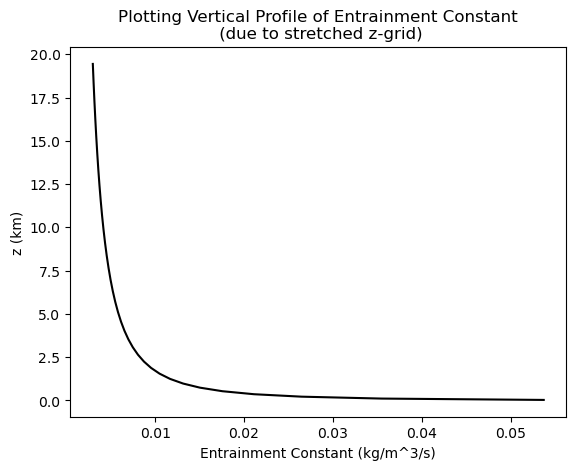

In [107]:
#calculating
outputDictionary_EntrainmentConstant = ComputeEntrainmentConstant()
entrainmentConstant = outputDictionary_EntrainmentConstant["entrainmentConstant"]

#saving
DataManager.Save1DVariable(DataManager.outputDataDirectory, outputDictionary_EntrainmentConstant, dataName="EntrainmentConstant",dtype="float32")

#plotting
plt.plot(entrainmentConstant,ModelData.zh,color='black')
plt.ylabel("z (km)")
plt.xlabel("Entrainment Constant (kg/m^3/s)")
plt.title("Plotting Vertical Profile of Entrainment Constant\n (due to stretched z-grid)");